###In this code I was getting negative utilities and oscillating power behaviour.
###The search range of c was found to be 1e13 to 1e15 theoretically to keep optimal power between 0 and 1

1. Utilities should not be negative
2. Power should converge between 0 and 1
3. True convergence based on epsilon

In [1]:
#import necessary libraries
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

####################################################----channel gain code----##############################################################
c = 3*10**8                                      #speed of light
h_BS = 3.5                                       # antenna height of the base station [m]
h_UT = 3.5                                       # antenna height of the user terminal [m]
h_E = 1                                          # effective environment height [m]
h_prime_BS = h_BS - h_E                          # effective antenna height of the base station [m]
h_prime_UT = h_UT - h_E   # effective antenna height of the user terminal [m]


def get_distance2D(p1, p2):
    d = np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)
    return d

def get_distance3D(p1, p2):
    d = np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 + (p1[2] - p2[2]) ** 2)
    return d

def get_PL_LOS(p1, p2, f_c):
    d_2D = get_distance2D(p1, p2)
    d_3D = get_distance3D(p1, p2)
    d_BP = (4 * h_prime_BS * h_prime_UT * f_c) / c
    PL_LOS = 0
    if (d_2D < 10):
        if (d_3D >= 1) and (d_3D <= 150):
            PL_LOS = 32.4 + 17.3*math.log10(d_3D) + 20*math.log10(f_c * 10**(-9))
    else:
        if (d_2D >= 10) and (d_2D <= d_BP):
            PL_LOS = 32.4 + 21*math.log10(d_3D) + 20*math.log10(f_c * 10**(-9))
        elif (d_2D >= d_BP) and (d_2D <= 5 * 10**3):
            PL_LOS = 32.4 + 40*math.log10(d_3D) + 20*math.log10(f_c * 10**(-9)) - 9.5*math.log10((d_BP)**2 + (p1[2] - p2[2])**2)
    return PL_LOS

def get_PL_NLOS(p1, p2, f_c):
    d_2D = get_distance2D(p1, p2)
    d_3D = get_distance3D(p1, p2)
    PL_prime_NLOS = 0
    if (d_2D < 10):
        if (d_3D >= 1) and (d_3D <= 150):
            PL_prime_NLOS = 17.3 + 38.3*math.log10(d_3D) + 24.9*math.log10(f_c * 10**(-9))
    else:
        if (d_2D >= 10) and (d_2D <= 5 * 10**3):
            PL_prime_NLOS = 22.4 + 35.3*math.log10(d_3D) + 21.3*math.log10(f_c * 10**(-9)) - 0.3*(p2[2] - 1.5)
    PL_NLOS = max(get_PL_LOS(p1, p2, f_c), PL_prime_NLOS)
    return PL_NLOS

#this function gives the probability that how much of the transmission is in Line of Sight
def get_Pr(p1, p2):
    d_2D = get_distance2D(p1, p2)
    if (d_2D < 10):
        if (d_2D <= 1.2):
            pr_LOS = 1
        elif (d_2D > 1.2) and (d_2D < 6.5):
            pr_LOS = math.exp(-(d_2D - 1.2)/4.7)
        elif (d_2D >= 6.5):
            pr_LOS = math.exp(-(d_2D - 6.5)/32.6) * 0.32
    else:
        if d_2D <= 18:
            pr_LOS = 1
        elif d_2D > 18:
            pr_LOS = (18/d_2D) + (math.exp(-d_2D/36) * (1 - (18/d_2D)))
    return pr_LOS

def get_PL(p1, p2, f_c):
    PL = get_Pr(p1, p2) * get_PL_LOS(p1, p2, f_c) + (1 - get_Pr(p1, p2)) * get_PL_NLOS(p1, p2, f_c)
    return PL

def get_channel_gain(p1, p2, f_c):
    g = 1 / 10**(get_PL(p1, p2, f_c) / 10)
    return g

###########################################-----BEST RESPONSE ALGORITHM-----###################################################################

#Initialising Variables
eta = 1 # Denoising factor at Receiver
epsilon = 1e-2
N = 5 # Number of Nodes
max_iteration = 100
P_max_vec = np.ones(N)
P_max_vec = np.array([10,10,10,10,10]) #maxpower possible for each nodes
P = np.random.uniform(0.1,1,N)
transmitter_ids = [1,2,3,4,5]
receiver_coordinates = (0, 0, 0)
transmitter_coordinates = [
    (7.5, 3.0, 2.25),    # d ≈ 8.25
    (12.0, 6.0, 3.0),    # d ≈ 13.8
    (16.5, 8.25, 3.75),  # d ≈ 19.0
    (21.0, 10.5, 4.5),   # d ≈ 24.4
    (25.5, 12.0, 5.25)   # d ≈ 29.0
]



#h contains channel gains for both the 5 nodes
h = [0 for i in range(N)]
for i in range(N):
    h[i] = get_channel_gain(transmitter_coordinates[i],receiver_coordinates,2405*10**6)

h = np.array(h)
print("Channel gain values are: ", h)
print("Initial Power values are: ", P)

Channel gain values are:  [9.37136965e-07 4.05027904e-07 2.05073317e-07 9.63273364e-08
 5.08245439e-08]
Initial Power values are:  [0.85302061 0.93288609 0.88628679 0.41979163 0.54348215]


In [2]:
# Compute conservative upper bound on c, this is the c from Theorem 2 in paper
c_max = 6.586e11
#c_max = eta / (4 * h1 * h2)
#print("The value of c is : ",c_max)


# ----- Utility Function -----
def utility_vector(P, h, c_max, eta):
    utilities = np.zeros(N)
    # Ensure P is a numpy array
    P = np.asarray(P)
    for n in range(N):
        gain_term = (h[n] * np.sqrt(P[n]) / np.sqrt(eta)) * \
                    np.sum([np.sqrt(P[m]) * h[m] / np.sqrt(eta) for m in range(N) if m != n])
        penalty_term = (c_max * h[n]**2 * P[n] / eta) * \
                       np.sum([P[m] * h[m]**2 / eta for m in range(N)])
        utilities[n] = gain_term - penalty_term
    return utilities

# ----- Closed-form P* Update -----
def closed_form_p_star(P, h, c_max):
    optimal_power = []
    sqrtP = np.sqrt(P)
    h2 = h ** 2
    #print("h squared is :",h2)
    for i in range(len(P)):
        mult = eta / (2 * c_max * h[i])
        sum1 = np.sum(h[j] * sqrtP[j] for j in range(len(P)) if i != j)
        sum2 = np.sum(h2[j] * P[j] for j in range(len(P)) if i != j)
        base = mult * (sum1 / sum2)

        print(f"\n[Debug - Node {i+1}]")
        print(f"h[i] = {h[i]:.3e}, mult = {mult:.3e}")
        print(f"sum1 = {sum1:.3e}, sum2 = {sum2:.3e}, base = {base:.3e}")

        P_star = base ** 2
        #P_star = np.clip(P_star, 0, P_max_vec[i])
        optimal_power.append(P_star)
    return np.array(optimal_power)

#Checking c values in range 1e13 to 1e15

In [4]:
#c_candidates = np.logspace(13, 15, 20)
c_candidates = np.logspace(13, 15, 10)# from 1e13 to 1e15, ~1.67× growth each step

found_c = None

for c_val in c_candidates:
    print(f"\n=== Testing c_max = {c_val:.3e} ===")
    c_max = c_val

    # Reset state for each c_max
    P_current = P.copy()
    utility_history = [utility_vector(P_current, h, c_max, eta)]

    power_history = [P_current.copy()]
    convergence = 0
    iteration = 0
    stop_due_to_negative = False

    while convergence == 0:
        iteration += 1

        # Step 1: Update P
        P_new = closed_form_p_star(P_current, h, c_max)
        power_history.append(P_new.copy())

        # Step 2: Compute utilities
        utilities_new = utility_vector(P_new, h, c_max, eta)
        print("Utility values are: ",utilities_new)

        # Step 3: Check for negative utility
        if np.any(utilities_new < 0):
            print(f"⚠ Negative utility at iteration {iteration}, trying next c_max.")
            stop_due_to_negative = True
            break

        utility_history.append(utilities_new.copy())

        # Step 4: Convergence check
        if np.linalg.norm(P_new - P_current) < epsilon or iteration == max_iteration:
            convergence = 1
        else:
            P_current = P_new

    print("---------------------------------")

    if not stop_due_to_negative:
        print(f"✅ Found suitable c_max = {c_max:.3e}, converged in {iteration} iterations.")
        df = pd.DataFrame({
            "Node": np.arange(1, N + 1),
            "Final Power P*": P_new,
            "Final Utility": utilities_new,
            "Channel Gain h": h
        })
        print(df)
        found_c = c_max
        break  # stop searching as we found the first valid c_max

if found_c is None:
    print("No c_max in the given range produced all positive utilities.")
else:
    print(f"Final chosen c_max = {found_c:.3e}")





=== Testing c_max = 6.586e+11 ===

[Debug - Node 1]
h[i] = 9.371e-07, mult = 8.101e-07
sum1 = 6.841e-07, sum2 = 1.956e-13, base = 2.833e+00

[Debug - Node 2]
h[i] = 4.050e-07, mult = 1.874e-06
sum1 = 1.158e-06, sum2 = 7.917e-13, base = 2.743e+00

[Debug - Node 3]
h[i] = 2.051e-07, mult = 3.702e-06
sum1 = 1.357e-06, sum2 = 9.075e-13, base = 5.534e+00

[Debug - Node 4]
h[i] = 9.633e-08, mult = 7.881e-06
sum1 = 1.487e-06, sum2 = 9.409e-13, base = 1.246e+01

[Debug - Node 5]
h[i] = 5.082e-08, mult = 1.494e-05
sum1 = 1.512e-06, sum2 = 9.434e-13, base = 2.394e+01
Utility values are:  [-4.56312972e-11 -3.25863124e-12 -3.58105089e-12 -4.50828756e-12
 -4.76164066e-12]
⚠ Negative utility at iteration 1, trying next c_max.
---------------------------------
❌ No c_max in the given range produced all positive utilities.


/tmp/ipython-input-804103817.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum1 = np.sum(h[j] * sqrtP[j] for j in range(len(P)) if i != j)
/tmp/ipython-input-804103817.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum2 = np.sum(h2[j] * P[j] for j in range(len(P)) if i != j)


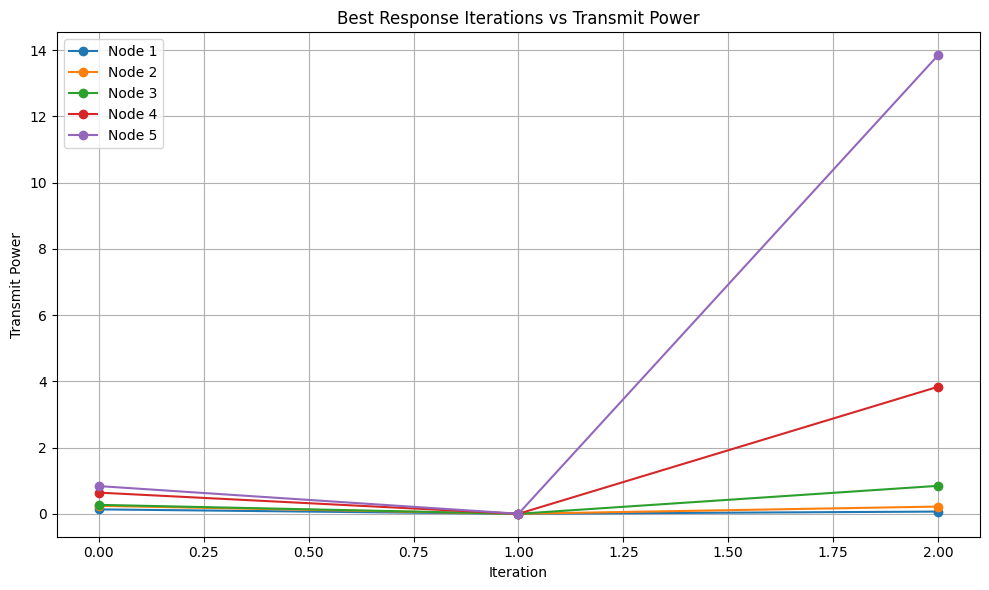

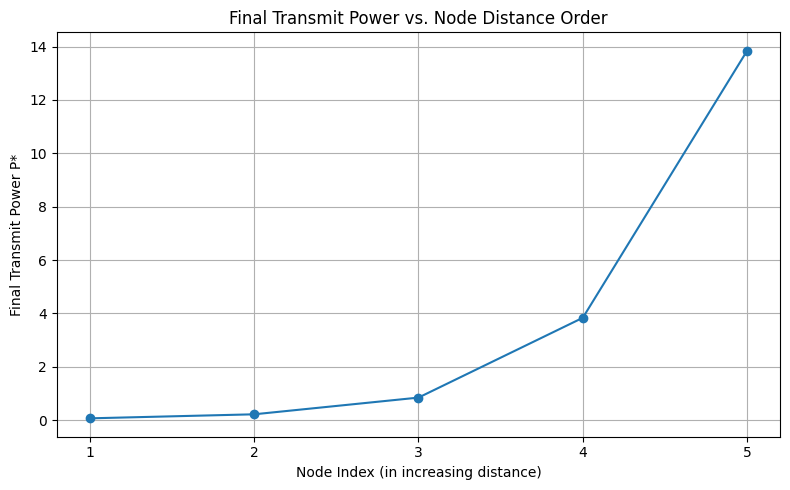

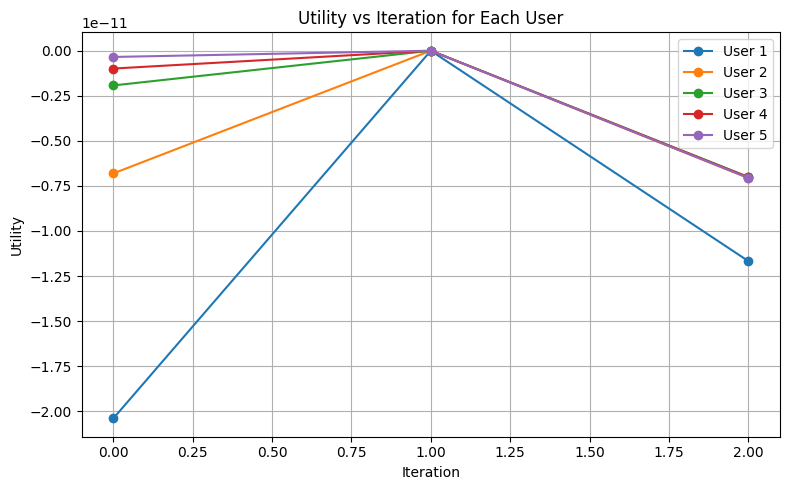

In [ ]:
# Plot 1
power_array = np.array(power_history)
plt.figure(1,figsize=(10, 6))
for n in range(N):
    plt.plot(power_array[:, n], marker='o', label=f'Node {n+1}')

plt.title("Best Response Iterations vs Transmit Power")
plt.xlabel("Iteration")
plt.ylabel("Transmit Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2
nodes_sorted = np.arange(1, N + 1)
plt.figure(2,figsize=(8, 5))
plt.plot(nodes_sorted, P_new, marker='o')
plt.xlabel("Node Index (in increasing distance)")
plt.ylabel("Final Transmit Power P*")
plt.title("Final Transmit Power vs. Node Distance Order")
plt.grid(True)
plt.xticks(nodes_sorted)
plt.tight_layout()
plt.show()


#Plot 3
plt.figure(figsize=(8, 5))
for n in range(N):
    plt.plot(np.arange(len(utility_history)), [u[n] for u in utility_history], marker='o', label=f'User {n+1}')
plt.xlabel("Iteration")
plt.ylabel("Utility")
plt.title("Utility vs Iteration for Each User")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()